# SET Dataset

Importiamo i dati dal dataset «[A multi-source dataset of urban life in the city of Milan and the Province of Trentino](https://www.nature.com/articles/sdata201555)». Il dataset contiene records di dati dall'infrastruttura delle telecomunicazioni, dati meteo, notizie, social networks e dati del consumo elettrico della città di Milano e della Provincia di Trento.

Intanto importiamo le librerie che ci serviranno.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import json
from shapely.geometry import Point, shape, Polygon, MultiPolygon
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime
import numpy as np
data_path = Path('data')

Poi importiamo i datasets in dataframe.

In [2]:
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson'}

def load_data(path):
    set1 = pd.read_csv(path / files['SET-1'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    set2 = pd.read_csv(path / files['SET-2'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    lines = pd.read_csv(path / files['SET-lines'])
    precip = pd.read_csv(path / files['precip'], names = ['TIMESTAMP','CELL_ID', 'INTENSITA'])
    precip_avail = pd.read_csv(path / files['precip-avail'], names = ['TIMESTAMP', 'AFFIDABILE'])
    with open(path / files['weather']) as f:
        meteo_json = json.load(f)
    meteo = gpd.GeoDataFrame(meteo_json['features'])
    meteo['geometry'] = meteo['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    meteo.drop(columns=['geomPoint.geom'], inplace=True)
    grid = gpd.read_file(path / files['grid'])
    with open(path / files['twitter']) as f:
        tweets_json = json.load(f)
    tweets = gpd.GeoDataFrame(tweets_json['features'])
    tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    tweets.drop(columns=['geomPoint.geom'], inplace=True)
    with open(path / files['adm_reg']) as f:
        regions_json = json.load(f)
    regions = gpd.GeoDataFrame(regions_json['items'])
    localunits = pd.read_csv(path / 'localunits.csv')
    localunitworkers = pd.read_csv(path / 'localunitworkers.csv')
    return set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, localunits, localunitworkers

In [3]:
set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, lu, luw = load_data(data_path)

## Preparare i Dati

Adesso prepariamo il dataset dei consumi elettrici. Per entrambi i dataset (di Novembre `SET-1` e di Dicembre `SET-2`) normalizziamo i consumi in rapporto al consumo totale della linea con un fattore dato dalle utenze presenti sulla linea nella cella, quindi restituiamo un GeoDataFrame con la geometria delle cellette e il consumo totale nella celletta.

In [4]:
def findnorm(df1, df2, row):
    return df1['NR_UBICAZIONI'][row] / df2.loc[df1['LINESET'][row]]

def get_cons_grid(setdf, linesdf, gridgdf):
    month_cons = setdf.groupby(['LINESET']).sum()
    # Troviamo il numero totale di utenze per linea
    lineuser = linesdf.groupby(['LINESET']).sum()['NR_UBICAZIONI']
    # Troviamo il fattore di normalizzazione
    linesdf['norm'] = [findnorm(linesdf, lineuser, row) for row in linesdf['NR_UBICAZIONI']]
    def findcons(df1, df2, row):
        try:
            result = df1['norm'][row] * df2.loc[df1['LINESET'][row]][0]
        except:
            result = None
        return result
    linesdf['cons'] = [findcons(linesdf, month_cons, row) for row in linesdf['NR_UBICAZIONI']]
    cellcons = linesdf.groupby(['SQUAREID'])[['cons']].sum()
    consgrid = pd.merge(gridgdf, cellcons, left_on='cellId', right_on='SQUAREID', how='left')
    consgrid['cons'].fillna(0, inplace=True)
    return consgrid

In [5]:
consgrid1 = get_cons_grid(set1, lines, grid)
consgrid2 = get_cons_grid(set2, lines, grid)
consgrid1['geometry'] = consgrid1['geometry'].centroid
consgrid2['geometry'] = consgrid2['geometry'].centroid

In [6]:
consgrid1

cellId                   geometry         cons
0         38  POINT (10.92089 45.67740)     0.000000
1         39  POINT (10.93372 45.67718)     0.000000
2         40  POINT (10.94655 45.67697)     0.000000
3        154  POINT (10.90836 45.68661)     0.000000
4        155  POINT (10.92119 45.68640)  5116.662782
...      ...                        ...          ...
6570   11336  POINT (11.81103 46.52301)     0.000000
6571   11337  POINT (11.82405 46.52269)     0.000000
6572   11452  POINT (11.79847 46.53232)     0.000000
6573   11453  POINT (11.81149 46.53200)     0.000000
6574   11454  POINT (11.82452 46.53168)     0.000000

[6575 rows x 3 columns]

Otteniamo allora i plot dei **consumi totali** dei mesi di Novembre e Dicembre.

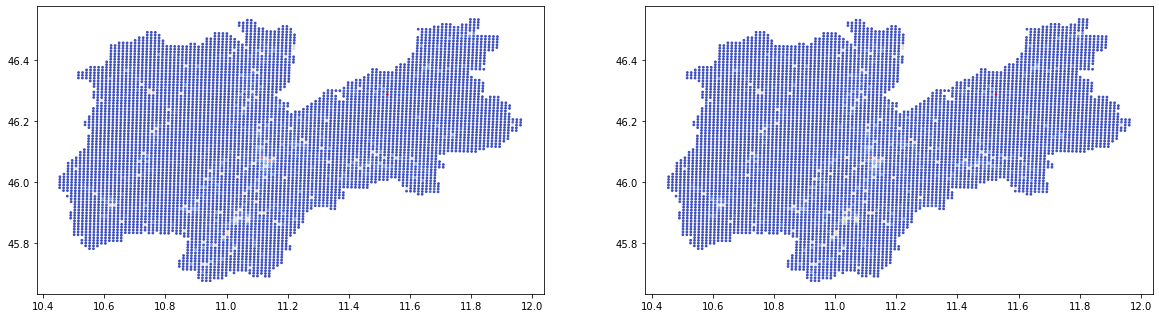

In [7]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#consgrid1.plot('cons', cmap='viridis', missing_kwds = dict(color = "lightgrey",), ax=ax1)
#consgrid2.plot('cons', cmap='viridis', missing_kwds = dict(color = "lightgrey",), ax=ax2)
consgrid1.plot('cons', marker='.', markersize=12, cmap='coolwarm', ax=ax1)
consgrid2.plot('cons', marker='.', markersize=12, cmap='coolwarm', ax=ax2)
plt.show()

Finora abbiamo cercato di visualizzare i consumi totali dei mesi di Novembre e Dicembre in Trentino. Ora visualizziamo prima di tutto, per tutte le linee, il consumo medio per giorno della settimana.

In [8]:
def plotWeekAvgLine(setdf, start, end):
    setdf['datetime'] = pd.to_datetime(setdf['TIMESTAMP'])
    #setdf_copy = setdf[((setdf['LINESET'] == lineset) & (setdf['datetime'] >= np.datetime64(start)) & (setdf['datetime'] < np.datetime64(end)))]
    setdf_copy = setdf[((setdf['datetime'] >= np.datetime64(start)) & (setdf['datetime'] < np.datetime64(end)))]
    setdf_copy['weekday'] = setdf_copy['datetime'].apply(lambda x: x.strftime('%A'))
    setdf_copy['time'] = [d.time() for d in setdf_copy['datetime']]
    setdf_copy_1=setdf_copy.groupby(['weekday', 'time']).mean()
    display(setdf_copy_1)
    ax1 = plt.gca()
    ax1.grid()
    daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for dd in daysofweek:
        setdf_copy_1.iloc[setdf_copy_1.index.get_level_values('weekday') == dd].plot(ax = ax1, label=dd)
        #plt.plot(x, y)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=70)
    ax1.legend(daysofweek, loc='best')
    ax1.grid()
    ax1.set_xticklabels(['00:00', '00:00', '03:20', '06:40', '10:00', '13:20', '16:40', '20:00', '23:20'])
    ax1.set_xlabel('time of the day [hh:mm]')
    ax1.set_ylabel('power consumption')

POWER
weekday   time               
Friday    00:00:00  27.415223
          00:10:00  27.180152
          00:20:00  26.967108
          00:30:00  26.681244
          00:40:00  26.445772
...                       ...
Wednesday 23:10:00  30.665292
          23:20:00  30.219837
          23:30:00  29.680448
          23:40:00  29.121386
          23:50:00  28.595740

[1008 rows x 1 columns]

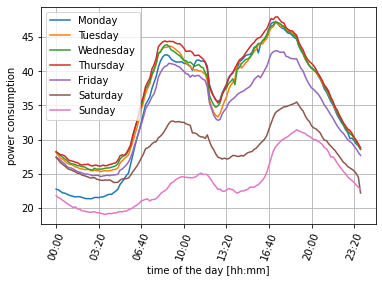

In [9]:
plotWeekAvgLine(set1, '2013-11-01 00:00', '2013-11-30 23:50')
plt.show()

Adesso, utilizzando la funzione `getTSdf`, otteniamo un dataframe che associa ogni `cellId` ad una time serie che rappresenta l'evoluzione temporale della potenza nella cella.

In [10]:
def getTSdf(setdf, linesdf):
    tsdf = setdf.groupby('LINESET')['POWER'].apply(lambda x: np.array(x)).reset_index()
    # Ci sono delle time series con qualche elemento di troppo, rimuoviamoli in modo che possiamo confrontare le serie tra loro
    for index, row in tsdf.iterrows():
        tsl = len(tsdf['POWER'][index])
        if (tsl != 4318):
            timecorrection = tsl-4318
            tsdf.iloc[index]['POWER'] = (tsdf.iloc[index]['POWER'][:-timecorrection])
    tsdf_lines = pd.merge(linesdf, tsdf, left_on='LINESET', right_on='LINESET', how='left')
    # Definiamo le time series "pesate" per l'uso nella cella e sommiamo le serie per tutte le linee presenti sulla cella
    tsdf_lines['wp'] = tsdf_lines['POWER']*tsdf_lines['norm']
    tsdf_cells = tsdf_lines.groupby('SQUAREID').wp.apply(np.sum)
    df1 = tsdf_cells.reset_index()
    df1['wp'] = [np.zeros(4318) if np.any(x == 0) else x for x in df1.wp]
    df3 = pd.DataFrame(np.stack(df1.wp.values))
    resultdf = pd.concat([df1, df3], axis=1)
    return resultdf.drop('wp', axis=1)

In [11]:
df1 = getTSdf(set1, lines)

In [12]:
df1.to_csv('data/ts1.csv', index=False)

In [52]:
setcopy_4 = set1.copy()
setcopy_4['time'] = [str(x.time()) for x in setcopy_4['datetime']]
setcopy_4['time'] = pd.to_timedelta(setcopy_4['time'])

In [60]:
setcopy_4[(setcopy_4['time'] > strtotime('18:55:00')) & (setcopy_4['time'] < strtotime('23:55:00'))]
setcopy_4

NameError: name 'strtotime' is not defined

In [59]:
np.timedelta64(1, 'W')

numpy.timedelta64(1,'W')

## Exploratory Data Analysis

Nella nostra EDA cerchiamo di comprendere la correlazione tra zone industrializzate, zone ad alta densità abitativa e i consumi elettrici del mese di Novembre. Utilizziamo dei dataset diversi da quelli forniti, visto che erano aggiornati al 2011 e quindi non contemplavano le soppressioni e le unioni dei comuni fatte nel frattempo. I dati delle divisioni amministrative sono quelli di OpenPolis, i dati della popolazione di I.Stat e i dati delle unità di lavoratori dell'ISPAT.

In [14]:
with open('data/tn_adm.json') as f:
    adm_json = json.load(f)
for d in adm_json['features']:
    d['geometry'] = shape(d['geometry'])
adm_gdf = gpd.GeoDataFrame(adm_json['features'])
adm = adm_gdf.from_features(adm_json['features'])
adm_red = adm[['geometry', 'name', 'com_catasto_code', 'com_istat_code']] # dataframe ridotto

In [15]:
population = pd.read_csv('data/tavola_pop_res01.csv')
population.columns = ['com_code', 'municipalities', 'm_pop', 'f_pop', 'tot_pop']
population['com_code'] = population['com_code'].apply(lambda x: int(x))

In [16]:
# Praticamente ci sono ancora alcuni dei comuni non accorpati (presumibilmente pre-2020)
with open('data/TavA25_2016.htm', 'r', encoding='ISO-8859-1') as file:
    localu = file.read().replace('\n', '')
localudf_raw = pd.read_html(localu)
localudf = localudf_raw[0][['Comuni', 'Industria in senso stretto', 'Costruzioni', 'Commercio, trasporti e pubblici esercizi', 'Altri servizi', 'Totale']]
localudf.columns = ['municipalities', 'industry', 'building', 'tertiary', 'other', 'total']
localudf = localudf.sort_values('municipalities')
col_list=['industry', 'building', 'tertiary', 'other', 'total']
localudf.loc[:, col_list] = localudf.loc[:, col_list].replace('-', 0)
#localudf['building'] = pd.to_numeric(localudf['building'])
#localudf['industry'] = pd.to_numeric(localudf['industry'])
localudf['building'] = localudf['building'].astype('int64')
localudf['industry'] = localudf['industry'].astype('int64')
newCityArr = ['Terre d\'Adige']
oldCitiesArr = [['Zambana', 'Nave San Rocco']]
for newCity, oldCities in zip(newCityArr, oldCitiesArr):
    dictNewCity = {'municipalities': newCity, **localudf[localudf['municipalities'].isin(oldCities)].sum(numeric_only=True).to_dict()}
    localudf = localudf.append((dictNewCity), ignore_index=True)
localudf = localudf[~localudf.municipalities.isin([val for sublist in oldCitiesArr for val in sublist])]

Eseguiamo un merge tra i tre dataset, in modo da ottenere un GeoDataFrame che contiene tutte le informazioni che ci servono. Inoltre eseguiamo un `sjoin` tra il GeoDataFrame appena ottenuto e il GeoDataFrame dei consumi per cella, scambiando la colonna `geometry` attualmente descritta dai quadrati con i propri centroidi e sommando i dati aggregati di consumo per ogni comune.

In [17]:
units_municip = pd.merge(adm_red, localudf, left_on='name', right_on='municipalities', how='left')
units_municip.crs = 'epsg:4326'
units_municip['com_code'] = units_municip['com_istat_code'].apply(lambda x: int(x))
#units_municip.plot('industry')
units_municip_pop = pd.merge(units_municip, population, how='left', left_on='com_code', right_on='com_code')
luconsraw_gdf = gpd.sjoin(units_municip_pop, consgrid1, how='left')
luconsdf = pd.merge(localudf, luconsraw_gdf.groupby('name')[['cons', 'tot_pop']].sum(), how='left', left_on='municipalities', right_on='name')

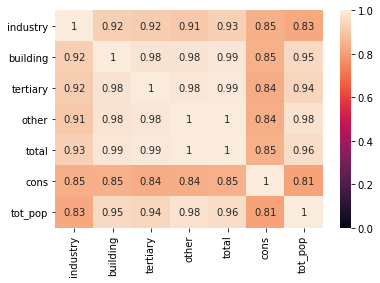

In [18]:
luconsCorr = luconsdf.corr()
sns.heatmap(luconsCorr, annot=True, vmin=0)
plt.show()

Vediamo come in realtà tutte le variabili considerate (addetti nel settore industriale, nel settore delle costruzioni, nel terziario, in altri settori, la popolazione totale ed i consumi elettrici) siano molto correlate tra loro. Sicuramente quindi luoghi con grandi consumi di elettricità corrispondono in buona approssimazione con luoghi ad alta densità abitativa e con luoghi con tanti lavoratori.

# Playground

In [19]:
regions_abc = regions.sort_values('name')
regions_abc = regions_abc[['cadastralCode', 'name', 'level', 'localCode', 'isMountainMunicipality']]
regions_abc_m = regions_abc[(regions_abc['level'] == 60)]
regions_abc_m

cadastralCode             name  level localCode isMountainMunicipality
158          A116              Ala     60    022001                      T
247          A158          Albiano     60    022002                      T
134          A178           Aldeno     60    022003                      T
32           A260           Amblar     60    022004                      T
68           A274           Andalo     60    022005                      T
..            ...              ...    ...       ...                    ...
169          M006    Villa Rendena     60    022223                      T
29           M113           Volano     60    022224                      T
3            M142          Zambana     60    022225                      T
71           M173  Ziano di Fiemme     60    022226                      T
242          M198            Zuclo     60    022227                      T

[217 rows x 5 columns]

In [20]:
comuni_it = pd.read_csv('data/comuni-italiani.csv', encoding='latin-1', delimiter=';')
#comuni_it.columns = ['Denominazione in Italiano', ]
comuni_it.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7903 entries, 0 to 7902
Data columns (total 23 columns):
 #   Column                                                                           Non-Null Count  Dtype 
---  ------                                                                           --------------  ----- 
 0   Codice Regione                                                                   7903 non-null   int64 
 1   Codice dell'Unità territoriale sovracomunale 
(valida a fini statistici)         7903 non-null   int64 
 2   Codice Provincia (Storico)(1)                                                    7903 non-null   int64 
 3   Progressivo del Comune (2)                                                       7903 non-null   int64 
 4   Codice Comune formato alfanumerico                                               7903 non-null   int64 
 5   Denominazione (Italiana e straniera)                                             7903 non-null   object
 6   Denominazione in

In [21]:
comuni_it = comuni_it[['Denominazione in italiano', 'Codice Catastale del comune', 'Codice NUTS3 2010']]
comuni_it.columns = ['municipalities', 'cadastralCode', 'NUTS3']
comuni_tn = comuni_it[(comuni_it['NUTS3'] == 'ITH20')]

In [22]:
comuni_tn.sort_values('municipalities')

municipalities cadastralCode  NUTS3
2877                       Ala          A116  ITH20
2878                   Albiano          A158  ITH20
2879                    Aldeno          A178  ITH20
3023                 Altavalle          M349  ITH20
3024  Altopiano della Vigolana          M350  ITH20
...                        ...           ...    ...
3013            Villa Lagarina          L957  ITH20
3037           Ville d'Anaunia          M363  ITH20
3042           Ville di Fiemme          M431  ITH20
3014                    Volano          M113  ITH20
3015           Ziano di Fiemme          M173  ITH20

[166 rows x 3 columns]